<h1><center>Trabajo Practico 2019 - Reciclaje en CABA</center></h1>
<h3><center>Pesaje Recibido en Puntos Verdes (2015-2016) en kilogramos</center></h3>

### Primero importamos las librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings; warnings.filterwarnings('ignore')

### Importamos el Dataset de reciclaje

In [2]:
comas_por_puntos = lambda x : (x.replace('.', '').replace(',', '.'))

filename = r'C:\Users\DeMartinCal\Desktop\reciclaje\pesaje-recibido-en-puntos-verdes-2015-2016.csv'
pesajes = pd.read_csv(filename, delimiter=';', decimal='.',
          converters = {'VIDRIO':comas_por_puntos,'PAPEL_Y_CARTON':comas_por_puntos,'METAL':comas_por_puntos,'PLASTICO_PET':comas_por_puntos,
                        'TELGOPOR':comas_por_puntos,'PLASTICOS_TODOS_LOS_DEMAS':comas_por_puntos,'TETRA_BRICK':comas_por_puntos,'PEQUENIOS_ELECTRODOMESTICOS':comas_por_puntos,
                        'APARATOS_ELECTRONICOS_EN_DESUSO':comas_por_puntos,'AVUS':comas_por_puntos})

### Hacemos una primera vision superficial del Dataset

In [3]:
print(f'\nPesajes tiene: {np.shape(pesajes)[0]} filas y {np.shape(pesajes)[0]} columnas')
pesajes.head(3)


Pesajes tiene: 3080 filas y 3080 columnas


,PUNTO,COMUNA,ANIO,MES,SEMANA,VIDRIO,PAPEL_Y_CARTON,METAL,PLASTICO_PET,TELGOPOR,PLASTICOS_TODOS_LOS_DEMAS,TETRA_BRICK,PEQUENIOS_ELECTRODOMESTICOS,APARATOS_ELECTRONICOS_EN_DESUSO,AVUS
0,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,1,31.2,20.7,0.27,,0,13.41,0,,,
1,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,2,2.231,44.878,0,,0,37.886,0.54,,,
2,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,3,38.042,27.763,1.067,,0,17.57,0,,,


In [4]:
comunas_distintas = np.unique(pesajes.COMUNA)
print(f'Hay {len(comunas_distintas)} comunas distintas')
puntos_distintos = np.unique(pesajes.PUNTO)
print(f'Hay {len(puntos_distintos)} puntos distintos distribuidos entre las comunas')

Hay 15 comunas distintas
Hay 32 puntos distintos distribuidos entre las comunas


In [5]:
# Primero reemplazo las cadenas vacias y los espacios ' ' por valor NaN para poder contarlos mas facil
pesajes = pesajes.replace('', np.nan).replace(' ', np.nan)
total = pesajes.isnull().sum().sort_values(ascending=False)
percent = (pesajes.isnull().sum()/pesajes.isnull().count()).sort_values(ascending=False)
nulos = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
nulos

,Total,Porcentaje
AVUS,2993,0.971753
APARATOS_ELECTRONICOS_EN_DESUSO,2872,0.932468
PEQUENIOS_ELECTRODOMESTICOS,2872,0.932468
PLASTICO_PET,1284,0.416883
TETRA_BRICK,738,0.239610
TELGOPOR,371,0.120455
METAL,371,0.120455
PAPEL_Y_CARTON,371,0.120455
VIDRIO,370,0.120130
PLASTICOS_TODOS_LOS_DEMAS,369,0.119805


#### Decidimos eliminar la columna de AVUs, y las de eletrodomesticos por tener menos del 90% de los datos
(solo estan en 2 comunas)

In [6]:
pesajes = pesajes.iloc[:,0:12]

#### Los PLASTICO_PET son de los materiales mas comunmente reciclables y lamentablemente es la columna de peor condición. Las filas, además de sus registros nulos, tambien poseen en su mayoria valores 0. Por lo tanto decidimos eliminarla también.

In [7]:
vaciosPET = np.shape(pesajes.loc[(pesajes['PLASTICO_PET'] == "0")])[0] + pesajes.isnull().sum()[8]
print("Valores vacios en PLASTICO_PET: " + str(vaciosPET))

Valores vacios en PLASTICO_PET: 2311


In [8]:
pesajes = pesajes.iloc[:,[0,1,2,3,4,5,6,7,9,10,11]]
pesajes.head(3)

,PUNTO,COMUNA,ANIO,MES,SEMANA,VIDRIO,PAPEL_Y_CARTON,METAL,TELGOPOR,PLASTICOS_TODOS_LOS_DEMAS,TETRA_BRICK
0,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,1,31.2,20.7,0.27,0,13.41,0
1,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,2,2.231,44.878,0,0,37.886,0.54
2,ESTACION VILLA SOLDATI,COMUNA 8,2015,ABRIL,3,38.042,27.763,1.067,0,17.57,0


#### Transformamos los meses a valores numéricos y separamos los años

In [9]:
meses = ["ENERO","FEBRERO","MARZO","ABRIL","MAYO","JUNIO","JULIO","AGOSTO","SEPTIEMBRE","OCTUBRE","NOVIEMBRE","DICIEMBRE"]
for i in range (1,13):
    pesajes.loc[ pesajes['MES'] == meses[i-1], 'MES'] = i

# Separo 2015 y 2016
pesajes_2015 = pesajes.loc[pesajes['ANIO'] == 2015]
pesajes_2016 = pesajes.loc[pesajes['ANIO'] == 2016]

#### El Dataset termina a la tercera semana de Septiembre de 2016 para todas las comunas excepto 2. Decidimos eliminar los siguientes meses para todas las comunas.

In [10]:
# Almacenamos los meses 10,11 y 12 de 2016 para las 2 comunas especiales (PLAZA ARENALES y PARQUE CENTENARIO)
pesajes_extra_Arenales_Centenario = pesajes.loc[((pesajes['ANIO'] == 2016) & (pesajes['MES'].isin([10,11,12])) & (pesajes['PUNTO'].isin(['PLAZA ARENALES','PARQUE CENTENARIO'])))]
pesajes_extra_Arenales_Centenario.head()

# Eliminamos los ultimos 3 meses
pesajes = pesajes.loc[~((pesajes['ANIO'] == 2016) & (pesajes['MES'].isin([10,11,12])))]

##   Criterios elegidos para limpiar el Dataframe de datos inutilizables faltantes
Dada la gran cantidad de datos faltantes o vacios, expresados de diversas formas, elegimos un criterio para seleccionar los puntos mas prometedores para trabajar.
### 1) Semana
    Si una semana esta llena de 0s, "", " ", NaNs es considerada VACIA
### 2) Mes
    Si un mes tiene 3 o más semanas VACIAS -> Esta VACIO
    Si un mes no esta cargado en el dataframe -> Esta VACIO
### 3) Punto
    Si un Punto tiene 4 o mas meses VACIOS en 2015 y 2016 -> Esta VACIO

#### Cuento los meses que aparecen tienen 3 o mas semanas vacias

In [11]:
#Primero filtro las que tienen meses con todas las filas llenas de cero (si tienen esas 3 vacias, el resto tambien)
filtro1 = pesajes_2015['VIDRIO'].isin([0,np.nan," "])
filtro2 = pesajes_2015['PAPEL_Y_CARTON'].isin([0,np.nan," "])
sin_vacio = (filtro1 & filtro2)
pesajes_2015_semanas_vacias = pesajes_2015[sin_vacio].drop_duplicates().sort_values(by=['PUNTO', 'MES','SEMANA']).copy().reset_index(drop=True)

filtro1 = pesajes_2016['VIDRIO'].isin([0,np.nan," "])
filtro2 = pesajes_2016['PAPEL_Y_CARTON'].isin([0,np.nan," "])
sin_vacio = (filtro1 & filtro2)
pesajes_2016_semanas_vacias = pesajes_2016[sin_vacio].drop_duplicates().sort_values(by=['PUNTO', 'MES','SEMANA']).copy().reset_index(drop=True)

#### Junto todas las tablas en una que muestre el estado de los Puntos segun datos vacios y faltantes

In [12]:
## Creo un df de los meses que tengo cargados de cada año, ordenados
meses_cargados_2015 = pesajes_2015.iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES']).copy().reset_index(drop=True)
meses_cargados_2016 = pesajes_2016.iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES']).copy().reset_index(drop=True)
    
## Los comparo y obtengo un df de todos los meses faltantes con PUNTO y MES
meses_faltantes = pd.merge(meses_cargados_2015, meses_cargados_2016,how='outer', indicator=True).query('_merge == "left_only"')
meses_faltantes_por_barrio = meses_faltantes.groupby(["PUNTO"])["MES"].count().sort_values(ascending=False)

Tabla_Faltantes = pd.concat([meses_faltantes_por_barrio], axis=1, keys=['Meses faltantes por barrio en 2016'])
Tabla_de_Vacios_Completa = (meses_faltantes.iloc[:,0:2]).groupby(["PUNTO"])["MES"].count().sort_values(ascending=False)
Tabla_de_Vacios_Completa = Tabla_de_Vacios_Completa.to_frame().rename(columns = {"MES":"Faltantes_2016"})

Agregar_a_tabla_vacias_filtrada_2016 = pesajes_2016_semanas_vacias.groupby(["PUNTO", "MES"]).filter(lambda x: x["SEMANA"].count() >= 3).iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES'])
Agregar_a_tabla_vacias_filtrada_2016 = Agregar_a_tabla_vacias_filtrada_2016.groupby(["PUNTO"]).size().to_frame().rename(columns = {0: "Vacios_2016"})
Agregar_a_tabla_vacias_filtrada_2015 = pesajes_2015_semanas_vacias.groupby(["PUNTO", "MES"]).filter(lambda x: x["SEMANA"].count() >= 3).iloc[:,[0,3]].drop_duplicates().sort_values(by=['PUNTO', 'MES'])
Agregar_a_tabla_vacias_filtrada_2015 = Agregar_a_tabla_vacias_filtrada_2015.groupby(["PUNTO"]).size().to_frame().rename(columns = {0: "Vacios_2015"})

Tabla_de_Vacios_Completa = pd.merge(Tabla_de_Vacios_Completa, Agregar_a_tabla_vacias_filtrada_2016, how='left', on='PUNTO').fillna(0)
Tabla_de_Vacios_Completa = pd.merge(Tabla_de_Vacios_Completa, Agregar_a_tabla_vacias_filtrada_2015, how='left', on='PUNTO').fillna(0)
Tabla_de_Vacios_Completa['Meses_No_Utilizables'] = Tabla_de_Vacios_Completa.Faltantes_2016 + Tabla_de_Vacios_Completa.Vacios_2016 + Tabla_de_Vacios_Completa.Vacios_2015

#### Decidimos borrar estos 4 Puntos por no cumplir el criterio de meses Vacios que definimos.

In [13]:
pesajes_criterio_de_limpieza = pesajes.loc[~pesajes['PUNTO'].isin(['ESTACION VILLA SOLDATI','PLAZA 25 DE AGOSTO','PLAZA VELAZCO IBARRA','PLAZA SAN MARTIN'])]

# Muestro la tabla ordenada por Meses No utilizables. Solo muestro los que no cumplen el criterio de meses faltantes
Tabla_de_Vacios_Completa.sort_values(by=['Meses_No_Utilizables'],ascending=False).iloc[0:4,:]

,Faltantes_2016,Vacios_2016,Vacios_2015,Meses_No_Utilizables
PUNTO,,,,
PLAZA 25 DE AGOSTO,4,8.0,11.0,23.0
ESTACION VILLA SOLDATI,4,8.0,4.0,16.0
PLAZA VELAZCO IBARRA,3,0.0,4.0,7.0
PLAZA M BELGRANO,3,2.0,0.0,5.0


#### Observando el Dataset pudimos ver que existen muchos nulos en ciertas quintas semanas de 2015 y 2016, estas semanas al corroborar con el calendario tenian muy pocos días. Asuminos esta como la razon de porque no se cargaron en casi ninguna comuna y las eliminamos

Podemos ver el estado actual de nulos para compararlo cuando eliminemos las quintas semanas del mes 6 y 11 para 2015 y el mes 1 y 9 para 2016

In [14]:
pesajes_con_nulo = pesajes_criterio_de_limpieza.replace('', np.nan).replace(' ', np.nan)
pesajes_1 = pesajes_con_nulo.loc[~((pesajes_con_nulo['ANIO'] == 2015) & (pesajes_con_nulo['MES'] == 6) & (pesajes_con_nulo['SEMANA'] == 5))]
pesajes_2 = pesajes_1.loc[~((pesajes_1['ANIO'] == 2015) & (pesajes_1['MES'] == 11) & (pesajes_1['SEMANA'] == 5))]
pesajes_3 = pesajes_2.loc[~((pesajes_2['ANIO'] == 2016) & (pesajes_2['MES'] == 1) & (pesajes_2['SEMANA'] == 5))]
pesajes_sin_quinta_vacias = pesajes_3.loc[~((pesajes_3['ANIO'] == 2016) & (pesajes_3['MES'] == 9) & (pesajes_3['SEMANA'] == 5))]

pesajes_ordenado = pesajes_sin_quinta_vacias.sort_values(by=['ANIO','MES'])
print("Nulos restantes"); pesajes_ordenado.isnull().sum()[pesajes_ordenado.isnull().sum() > 0]

Nulos restantes


VIDRIO                        38
PAPEL_Y_CARTON                39
METAL                         39
TELGOPOR                      39
PLASTICOS_TODOS_LOS_DEMAS     37
TETRA_BRICK                  377
dtype: int64

#### Como termina en la tercera semana de Septiembre de 2016, la cuarta esta vacia. Decidimos llenar esta cuarta semana con una media da las primeras 3 semanas

In [15]:
for indice in range(0, len(pesajes_ordenado)):
    if ((pesajes_ordenado.iloc[indice,2:5] == [2016, 9, 4]).all()):
        media = round((pesajes_ordenado.iloc[indice-3,5:12].apply(lambda x: float(x)) +
                 pesajes_ordenado.iloc[indice-2,5:12].apply(lambda x: float(x)) +
                 pesajes_ordenado.iloc[indice-1,5:12].apply(lambda x: float(x)))
                 /3, 3)
        pesajes_ordenado.iloc[indice,5:12] = media.apply(lambda x: str(x))
        
#Relleno a mano 5 excepciones con las medias de los meses cercanos a ellas
for i in range (0,5):
    pesajes_ordenado.iloc[1996+i,5:12] = pesajes_ordenado.iloc[1967,5:12]
    
pesajes_ordenado.loc[2038,'PLASTICOS_TODOS_LOS_DEMAS'] = pesajes_ordenado.loc[2037,'PLASTICOS_TODOS_LOS_DEMAS']
print("Nulos restantes"); pesajes_ordenado.isnull().sum()[pesajes_ordenado.isnull().sum() > 0]

Nulos restantes


VIDRIO                        12
PAPEL_Y_CARTON                13
METAL                         13
TELGOPOR                      13
PLASTICOS_TODOS_LOS_DEMAS     10
TETRA_BRICK                  351
dtype: int64

#### El resto de nulos (sin incluir tetra_brick) que quedan los rellenamos haciendo un promedio de sus semanas llenas en ese mes.

In [16]:
pesajes_ordenado = pesajes_ordenado.replace('nan', np.nan)
VidriosNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,5].isnull()] #VIDRIOS
PyCNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,6].isnull()]     #PAPEL Y CARTON
MetalNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,7].isnull()]   #METAL
TelgoporNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,8].isnull()]#TELGOPOR
Plasticos = pesajes_ordenado[pesajes_ordenado.iloc[:,9].isnull()]    #PLASTICOS_TODOS_LOS_DEMAS
matsNulos = [VidriosNulos, PyCNulos, MetalNulos, TelgoporNulos, Plasticos]
material = ['VIDRIO','PAPEL_Y_CARTON','METAL','TELGOPOR','PLASTICOS_TODOS_LOS_DEMAS']

# Relleno con la media de las semanas restantes del mes con algunas nulas mas las del siguiente y el anterior
for m in range(0, 5):
    for i in range(0, len(matsNulos[m])):
        mesActual = matsNulos[m]['MES'].iloc[i]
        medias = (pesajes_ordenado.loc[(pesajes_ordenado['MES'].isin([mesActual, mesActual-1, mesActual+1])) & (pesajes_ordenado['ANIO'] == matsNulos[m]['ANIO'].iloc[i]) & (pesajes_ordenado['PUNTO'] == matsNulos[m]['PUNTO'].iloc[i]) & 
                                       (pesajes_ordenado[material[m]].notnull())].iloc[:,[5,6,7,9,10]]).apply(lambda x: x.apply(lambda x: float(x))).mean().apply(lambda x: str(round(x,2)))
        count = 0
        for c in ['VIDRIO','PAPEL_Y_CARTON','METAL','TELGOPOR','PLASTICOS_TODOS_LOS_DEMAS']:
            pesajes_ordenado.loc[matsNulos[m].index[i], c] = medias[count]
            count+=1

pesajes_ordenado = pesajes_ordenado.replace('nan', np.nan)
print("Nulos restantes"); pesajes_ordenado.isnull().sum()[pesajes_ordenado.isnull().sum() > 0]

Nulos restantes


TETRA_BRICK    352
dtype: int64

#### Por ultimo llenamos los Tetra Bricks que faltan usando las medias de las semanas(o mes en peor caso) anterior y siguiente

In [17]:
# En meses 1,2 y 3 de 2015 estan casi todos los vacios, los relleno con la media en el mismo punto de los meses 4 y 5
EneFebMar_TetraNulos = pesajes_ordenado.loc[(pesajes_ordenado['ANIO'] == 2015) & (pesajes_ordenado['MES'].isin([1,2,3])) & (pesajes_ordenado['TETRA_BRICK'].isnull())]

# Relleno con la media del los meses 4 y 5 que sean de mismo Punto
for i in range(0, len(EneFebMar_TetraNulos)):
    media = (pesajes_ordenado.loc[(pesajes_ordenado['MES'].isin([4,5])) & (pesajes_ordenado['ANIO'] == 2016) & (pesajes_ordenado['PUNTO'] == EneFebMar_TetraNulos['PUNTO'].iloc[i]) & 
                              (pesajes_ordenado['TETRA_BRICK'].notnull())].iloc[:,10]).apply(lambda x: float(x)).mean()
    media = str(round(media,2))
    pesajes_ordenado.loc[EneFebMar_TetraNulos.index[i],'TETRA_BRICK'] = media

# Los pocos Nulos faltantes los lleno las semanas con las medias de sus respectivos meses en sus respectivos puntos
TetraUltimosNulos = pesajes_ordenado[pesajes_ordenado.iloc[:,10].isnull()]
for i in range(0, len(TetraUltimosNulos)):
    mesActual = TetraUltimosNulos['MES'].iloc[i]
    media = (pesajes_ordenado.loc[(pesajes_ordenado['MES'].isin([mesActual, mesActual-1, mesActual+1])) & (pesajes_ordenado['ANIO'] == TetraUltimosNulos['ANIO'].iloc[i]) & (pesajes_ordenado['PUNTO'] == TetraUltimosNulos['PUNTO'].iloc[i]) & 
                                  (pesajes_ordenado['TETRA_BRICK'].notnull())].iloc[:,10]).apply(lambda x: float(x)).mean()
    media = str(round(media,2))
    pesajes_ordenado.loc[TetraUltimosNulos.index[i],'TETRA_BRICK'] = media

print(f"\nVerificamos que no hayan quedado pesajes nulos  ->  {pesajes_ordenado.isnull().sum().any()}")


Verificamos que no hayan quedado pesajes nulos  ->  False


In [18]:
## Genero el archivo csv ya limpio y lo vuelvo a importar cambiando sus tipos a numeros flotantes para
#  que sea mas facil su manejo
import os
export_csv = pesajes_ordenado.to_csv(r'pesajes_nulos.csv', index = None, header=True, sep=';')
filename = os.getcwd() + "\\pesajes_nulos.csv"
pesajes = pd.read_csv(filename, delimiter=';', decimal='.')

<h1><center>Análisis Exploratorio de Datos</center></h1>

### Para comenzar el analisis vemos que diferencias existen entre el año 2015 y 2016 en los pesajes totales.

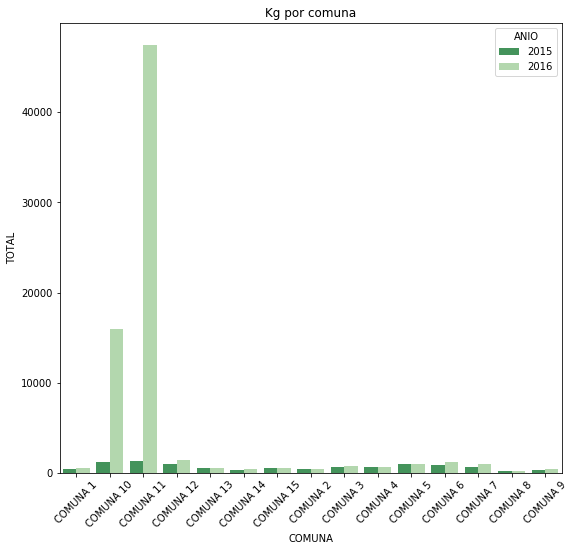

In [19]:
pesajes['TOTAL']= pesajes['VIDRIO'] + pesajes['PAPEL_Y_CARTON'] + pesajes['METAL'] + pesajes['TELGOPOR'] + pesajes['TETRA_BRICK'] + pesajes['PLASTICOS_TODOS_LOS_DEMAS'] 
chart = sns.barplot(x='COMUNA', y='TOTAL', hue='ANIO', data=pesajes.groupby(["COMUNA", "ANIO"], as_index=False).mean(), palette=("Greens_r"))
plt.title('Kg por comuna')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(9, 8.27)
pesajes = pesajes.drop('TOTAL', 1)

#### Se puede notar que el año 2016 posee mayor pesaje en todas sus comunas respecto del año 2015

#### Decidimos hacer el análisis por comuna en vez de por punto para poder cruzar los datos con otros datasets que se manejan por comuna. Empezamos con un analisis mensual general

In [20]:
pesajes_agrupados = pesajes.groupby(["COMUNA","ANIO", "MES"]).sum()
pesajes_agrupados.head(3)

SEMANA   VIDRIO  PAPEL_Y_CARTON  METAL  TELGOPOR  \
COMUNA   ANIO MES                                                     
COMUNA 1 2015 1        30  1047.52         1950.82  81.79    19.330   
              2        20   904.96         1819.81  59.57     7.150   
              3        20   824.58         1805.42  70.08     4.809   

                   PLASTICOS_TODOS_LOS_DEMAS  TETRA_BRICK  
COMUNA   ANIO MES                                          
COMUNA 1 2015 1                       415.91        62.35  
              2                       433.78        49.88  
              3                       592.81        49.88

Podemos observar que tanto telgopor, metal y tetrabrick no hay cantidades imporantes (menos de 100kg mensuales), salvo 2 o 3 casos aislados. No asi en plasticos, papel y vidrio, en donde se manejan grandes cantidades de kilos, plasticos con un promedio de 150 kilos, y tanto papel como vidrio con promedios de 250 kilos mensuales

#### Analizamos la correlacion de las features de pesajes

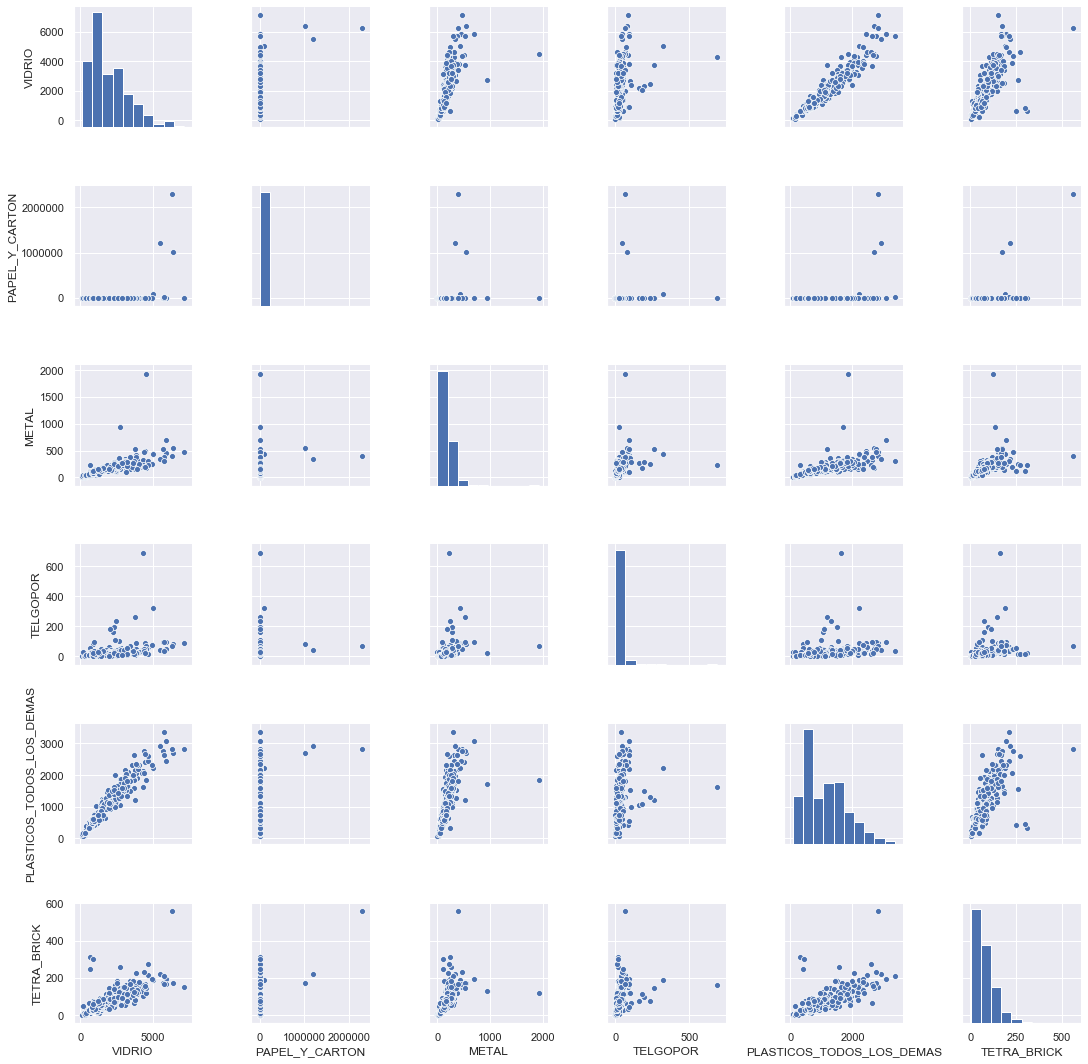

In [21]:
sns.set()
cols = ['VIDRIO', 'PAPEL_Y_CARTON', 'METAL', 'TELGOPOR', 'PLASTICOS_TODOS_LOS_DEMAS', 'TETRA_BRICK']
sns.pairplot(pesajes_agrupados[cols], size = 2.5)
plt.show()

Obvservamos que existe una en general una relacion lineal entre los pesajes, siendo telgopor el menos lineal con el resto. Tambien es elde menor peso y que menos se recicla

#### Ahora analizamos a grandes rasgos con un heatmap por comuna el total de materiales en los 2 años

In [22]:
pesajes_agrupados_comuna_limpio = pesajes.groupby(["COMUNA"]).sum().iloc[:,3:9]

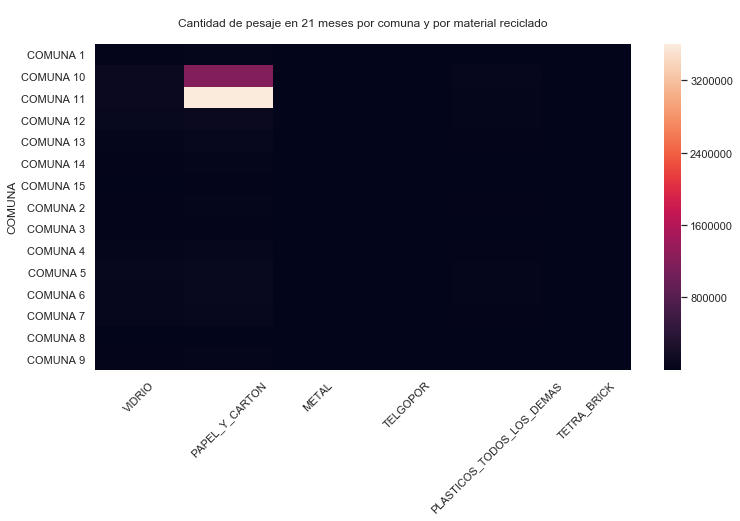

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(pesajes_agrupados_comuna_limpio)
plt.xticks(rotation=45)
plt.title("\nCantidad de pesaje en 21 meses por comuna y por material reciclado\n")
plt.show()

De este heatmap podemos sacar varias conclusiones: 
- El pesaje tanto de telgopor, tetrabrick y metal en comparacion a vidrio, papel, carton y plastico en infimo, se puede observar como sus columnas se encuentran bien oscuras. 
- La comuna 8 es la que menos recolecta en todos los reciclables, debido a su fila oscura en casi toda la totalidad, seguida por la 15 y la 9 que tambien recolectan poco en comparacion a las que mayor recoleccion tienen.
- La comuna 6 en lo general no tiene gran recoleccion pero hace un pico en papel y carton, por lo que vamos a analizar mas adelante porque hace ese pico, si es por una zona industrial cerca referida a papel y carton, o un mal calculo en algun momento que podemos notar en los percentiles.
- Las comunas 10, 11 y 12 son los que mayor recoleccion tuvieron.
- Papel y carton en la comuna 11 es el punto de mayor recoleccion que existe, viendose el rectangulo completamente blanco.

### Analisis de cada material

Ahora analizaremos caso por caso cada material para evaluar cantidad recogida
### Vidrio

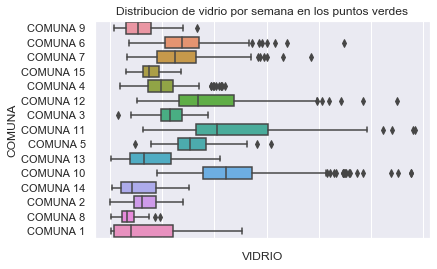

In [24]:
ay = sns.boxplot(x = pesajes.VIDRIO, y = pesajes.COMUNA, data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Distribucion de vidrio por semana en los puntos verdes")
plt.show()

Tanto la comuna 10 como la comuna 11 son las que mayor vidrio acumulan semana a semana, con la comuna 10 con mayor piso asegurado, mientras que la 8 es la que menos acumula.

#### Analizamos que valores mensuales se escapan del percentil 97 para visualizar la cantidad de anomalias que pueden sesgar nuestro modelo.

In [25]:
pesajes_agrupados = pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum()
percentil_97_vidrio = (pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum())['VIDRIO'].quantile(0.97)
valores_altos_vidiro = pesajes_agrupados.loc[pesajes_agrupados['VIDRIO']>percentil_97_vidrio].iloc[:,[0,2,4]]

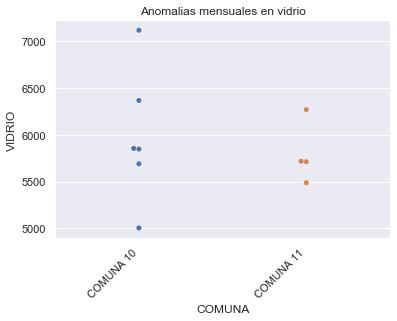

Solo la comuna 10 y 11 se tienen picos. Sus valores todos mayores a 4000 que se alejan de la media de 1935.0 y mediana de 1548.0


In [26]:
ay = sns.swarmplot(x = valores_altos_vidiro.COMUNA, y=valores_altos_vidiro['VIDRIO'], data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Anomalias mensuales en vidrio")
plt.xticks(rotation=45)
plt.show()

print(f"Solo la comuna 10 y 11 se tienen picos. Sus valores todos mayores a 4000 que se alejan de la media de {round(pesajes_agrupados['VIDRIO'].describe()[1])} y mediana de {round(pesajes_agrupados['VIDRIO'].describe()[5])}")

### Papel y Carton

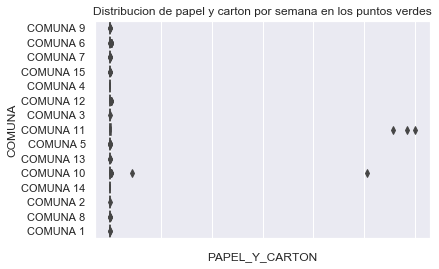

In [27]:
ay = sns.boxplot(x = pesajes.PAPEL_Y_CARTON, y = pesajes.COMUNA, data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Distribucion de papel y carton por semana en los puntos verdes")
plt.show()

En papel y carton vemos un proporcion parecida de anomalias que en vidrios, pero esta vez hay menos que en las comunas que mayores pesajes producen (10 y 11)

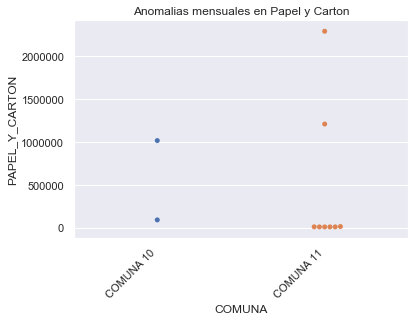

Solo las comunas 11 y 12 poseen anomalias. Cuyos valores todos mayores a 6000 que se alejan mucho de la media de 17124.0 y mediana de 2181.0


In [28]:
percentil_97_PyC = (pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum())['PAPEL_Y_CARTON'].quantile(0.97)
valores_altos_PyC = pesajes_agrupados.loc[pesajes_agrupados['PAPEL_Y_CARTON']>percentil_97_PyC].iloc[:,[0,2,5]]

ay = sns.swarmplot(x = valores_altos_PyC.COMUNA, y = valores_altos_PyC['PAPEL_Y_CARTON'], data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Anomalias mensuales en Papel y Carton")
plt.xticks(rotation=45)
plt.show()

print(f"Solo las comunas 11 y 12 poseen anomalias. Cuyos valores todos mayores a 6000 que se alejan mucho de la media de {round(pesajes_agrupados['PAPEL_Y_CARTON'].describe()[1])} y mediana de {round(pesajes_agrupados['PAPEL_Y_CARTON'].describe()[5])}")

### Metal

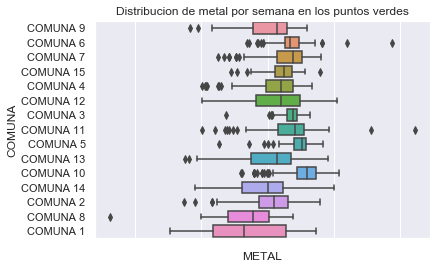

In [29]:
ay = sns.boxplot(x = np.log10(pesajes.METAL), y = pesajes.COMUNA, data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Distribucion de metal por semana en los puntos verdes")
plt.show()

En metal notamos muchas mas anomalias de valores demaciado pequeños mas que grandes, es importante tomarlo en cuenta cuando filtremos outliers

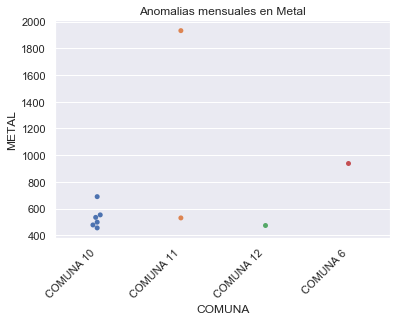

Las comunas 6, 10, 11 y 12 poseen anomalias. Cuyos valores todos mayores a 450 que se alejan de la media de 173.0 y mediana de 148.0


In [30]:
percentil_97_metal = (pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum())['METAL'].quantile(0.97)
valores_altos_metal = pesajes_agrupados.loc[pesajes_agrupados['METAL']>percentil_97_metal].iloc[:,[0,2,6]]

ay = sns.swarmplot(x = valores_altos_metal.COMUNA, y = valores_altos_metal['METAL'], data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Anomalias mensuales en Metal")
plt.xticks(rotation=45)
plt.show()

print(f"Las comunas 6, 10, 11 y 12 poseen anomalias. Cuyos valores todos mayores a 450 que se alejan de la media de {round(pesajes_agrupados['METAL'].describe()[1])} y mediana de {round(pesajes_agrupados['METAL'].describe()[5])}")

### Telgopor

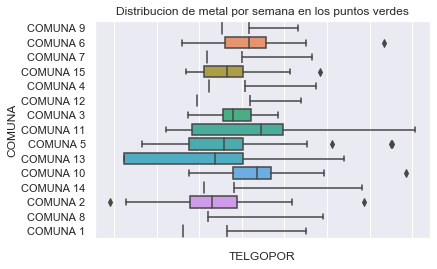

In [31]:
ay = sns.boxplot(x = np.log10(pesajes.TELGOPOR), y = pesajes.COMUNA, data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Distribucion de metal por semana en los puntos verdes")
plt.show()

Ahora ya obvservamos un numero muy chico de anomalias, esto nos dice que el telgopor tiene muy poca variabilidad y que sus valores estan mas concentrados.

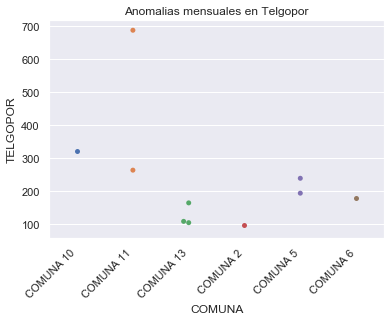

Las comunas 2, 5, 6, 10, 11 y 13 poseen anomalias. Cuyos valores todos mayores a 100 que se alejan de la media de 29.0 y mediana de 19.0


In [32]:
percentil_97_telgopor = (pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum())['TELGOPOR'].quantile(0.97)
valores_altos_telgopor = pesajes_agrupados.loc[pesajes_agrupados['TELGOPOR']>percentil_97_telgopor].iloc[:,[0,2,7]]

ay = sns.swarmplot(x = valores_altos_telgopor.COMUNA, y = valores_altos_telgopor['TELGOPOR'], data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Anomalias mensuales en Telgopor")
plt.xticks(rotation=45)
plt.show()

print(f"Las comunas 2, 5, 6, 10, 11 y 13 poseen anomalias. Cuyos valores todos mayores a 100 que se alejan de la media de {round(pesajes_agrupados['TELGOPOR'].describe()[1])} y mediana de {round(pesajes_agrupados['TELGOPOR'].describe()[5])}")

### Plasticos

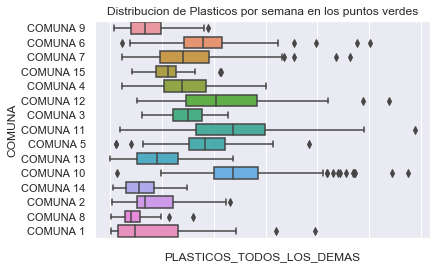

In [33]:
ay = sns.boxplot(x = pesajes.PLASTICOS_TODOS_LOS_DEMAS, y = pesajes.COMUNA, data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Distribucion de Plasticos por semana en los puntos verdes")
plt.show()

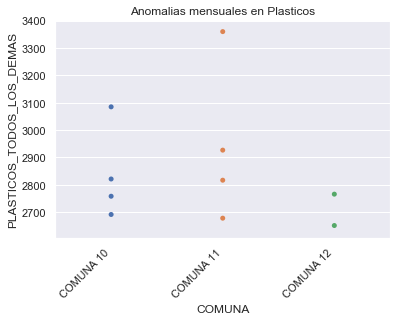

Las comunas 10, 11 y 12 poseen anomalias. Cuyos valores todos mayores a 2500 que se alejan de la media de 1118.0 y mediana de 1023.0


In [34]:
percentil_97_plasticos = (pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum())['PLASTICOS_TODOS_LOS_DEMAS'].quantile(0.97)
valores_altos_plasticos = pesajes_agrupados.loc[pesajes_agrupados['PLASTICOS_TODOS_LOS_DEMAS']>percentil_97_plasticos].iloc[:,[0,2,8]]

ay = sns.swarmplot(x = valores_altos_plasticos.COMUNA, y = valores_altos_plasticos['PLASTICOS_TODOS_LOS_DEMAS'], data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Anomalias mensuales en Plasticos")
plt.xticks(rotation=45)
plt.show()

print(f"Las comunas 10, 11 y 12 poseen anomalias. Cuyos valores todos mayores a 2500 que se alejan de la media de {round(pesajes_agrupados['PLASTICOS_TODOS_LOS_DEMAS'].describe()[1])} y mediana de {round(pesajes_agrupados['PLASTICOS_TODOS_LOS_DEMAS'].describe()[5])}")

### Tetrabrick

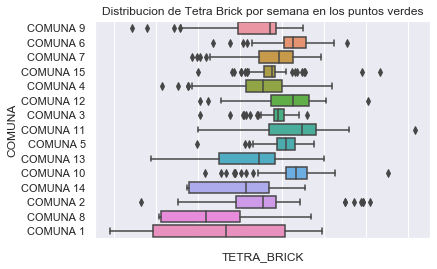

In [35]:
ay = sns.boxplot(x = np.log10(pesajes.TETRA_BRICK), y = pesajes.COMUNA, data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Distribucion de Tetra Brick por semana en los puntos verdes")
plt.show()

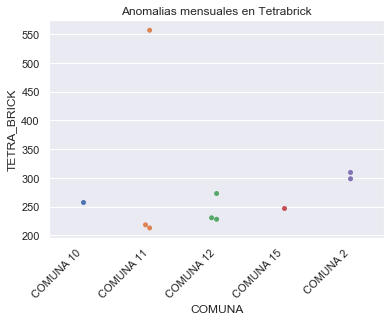

De vuelta vemos las comunas 10, 11 y 12 como en los demas pesajes, la 15 y 2 tambien poseen anomalias. Los valores son todos mayores a 200 que se alejan de la media de 78.0 y mediana de 63.0


In [36]:
percentil_97_tetrabrick = (pesajes.groupby(["COMUNA","ANIO", "MES"], as_index=False).sum())['TETRA_BRICK'].quantile(0.97)
valores_altos_tetrabrick = pesajes_agrupados.loc[pesajes_agrupados['TETRA_BRICK']>percentil_97_tetrabrick].iloc[:,[0,2,9]]

ay = sns.swarmplot(x = valores_altos_tetrabrick.COMUNA, y = valores_altos_tetrabrick['TETRA_BRICK'], data = pesajes_agrupados)
ay.set_xticklabels(ay.get_xticklabels(), rotation=90, ha="right")
plt.title("Anomalias mensuales en Tetrabrick")
plt.xticks(rotation=45)
plt.show()

print(f"De vuelta vemos las comunas 10, 11 y 12 como en los demas pesajes, la 15 y 2 tambien poseen anomalias. Los valores son todos mayores a 200 que se alejan de la media de {round(pesajes_agrupados['TETRA_BRICK'].describe()[1])} y mediana de {round(pesajes_agrupados['TETRA_BRICK'].describe()[5])}")

#### Conclusion, las anomalias se concentran principalmente en las comunas 10, 11 y 12. Esto claramente se debe a que tienen mayor pesaje promedio que el resto, lo que nos dice que el filtrado de outliers lo tenemos que hacer separado por comunas, de no hacerlo perderemos mas datos de las comunas que mas pesajes generan

### Analisamos la relacion entre los pesajes con el ingreso medio mensual de cada comuna usando el dataset de la fuente https://www.estadisticaciudad.gob.ar/eyc/?p=82447

In [37]:
pesajes_mediaSemanal = pesajes.iloc[:,[1,2,3,5,6,7,8,9,10]].groupby(["COMUNA","ANIO","MES"], as_index=False).mean()
pesajes_totalMensual = pesajes.iloc[:,[1,2,3,5,6,7,8,9,10]].groupby(["COMUNA","ANIO","MES"], as_index=False).sum()

In [38]:
ingreso_promedio = pd.read_csv(r'ingresos_promedios.csv', delimiter=';',decimal=',')

FileNotFoundError: [Errno 2] File b'ingresos_promedios.csv' does not exist: b'ingresos_promedios.csv'

In [ ]:
# Separo 2015 y 2016
ingreso_promedio_2015 = ingreso_promedio.loc[ingreso_promedio['ANIO'] == 2015]
ingreso_promedio_2016 = ingreso_promedio.loc[ingreso_promedio['ANIO'] == 2016]

In [ ]:
# Traducimos las comunas a solamente un numero

comunas_distintas_Pesajes = ['COMUNA 1', 'COMUNA 2', 'COMUNA 3', 'COMUNA 4', 'COMUNA 5', 'COMUNA 6', 'COMUNA 7','COMUNA 8',
                             'COMUNA 9', 'COMUNA 10', 'COMUNA 11', 'COMUNA 12', 'COMUNA 13', 'COMUNA 14', 'COMUNA 15']
for i in range (1,16):
    pesajes.loc[ pesajes['COMUNA'] == comunas_distintas_Pesajes[i-1], 'COMUNA'] = i
    ingreso_promedio_2015.loc[ ingreso_promedio_2015['COMUNA'] == comunas_distintas_Pesajes[i-1], 'COMUNA'] = i

ingreso_promedio_2015 = ingreso_promedio_2015.sort_values(by='COMUNA', ascending=True)

In [ ]:
pesajes_mediaMensual = pesajes_totalMensual.groupby(["COMUNA","ANIO"], as_index=False).mean()
pesajes_mediaMensual_2015 = pesajes_mediaMensual.loc[pesajes_mediaMensual['ANIO'] == 2015]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.2, 1.2))
pesajes_mediaMensual_2015.iloc[:,3:9] = scaler.fit_transform(pesajes_mediaMensual_2015.iloc[:,3:])
pesajes_mediaMensual_2015['Ingreso'] = scaler.fit_transform(pd.DataFrame(ingreso_promedio_2015.iloc[:,2]))

 #### Observamos la relacion entre ingreso recliclajes con los pesajes mas importantes: Vidrio, Papel y carton

In [ ]:
fig = plt.figure(figsize=(8,4)) # Create matplotlib figure
df = pesajes_mediaMensual_2015.set_index('COMUNA')       
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .35
df.Ingreso.plot(kind='bar',color='yellow',ax=ax,width=width, position=0,alpha=0.75)
df.VIDRIO.plot(kind='bar',color='green', ax=ax2,width=width, position=1,alpha=0.65)
ax.set_ylabel('Vidrio')
ax2.set_ylabel('Ingreso')
plt.xticks(rotation=45)
ax.set_xlim(-1,15)

fig = plt.figure(figsize=(8,4)) # Create matplotlib figure
df = pesajes_mediaMensual_2015.set_index('COMUNA')       
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .35
df.Ingreso.plot(kind='bar',color='yellow',ax=ax,width=width, position=0,alpha=0.75)
df.PAPEL_Y_CARTON.plot(kind='bar',color='green', ax=ax2,width=width, position=1,alpha=0.65)
ax.set_ylabel('Papel y Carton')
ax2.set_ylabel('Ingreso')
plt.xticks(rotation=45)
ax.set_xlim(-1,15)

#### Podemos observar que el ingreso medio mensual tiene una correlacion con la media de pesaje mensual por comuna. Podria decirse que mientras mas poder adquisitivo tiene la gente, mas recicla

### Por ultimo analizamos la estacionalidad de los datos, es decir ver como varian los pesajes a lo largo del año

In [41]:
pesajes_totalMensual = pesajes.iloc[:,[2,3,5,6,7,8,9,10]].groupby(["ANIO","MES"], as_index=False).sum()
anio2015=pesajes_totalMensual.loc[pesajes_totalMensual['ANIO'] == 2015]
anio2016=pesajes_totalMensual.loc[pesajes_totalMensual['ANIO'] == 2016]

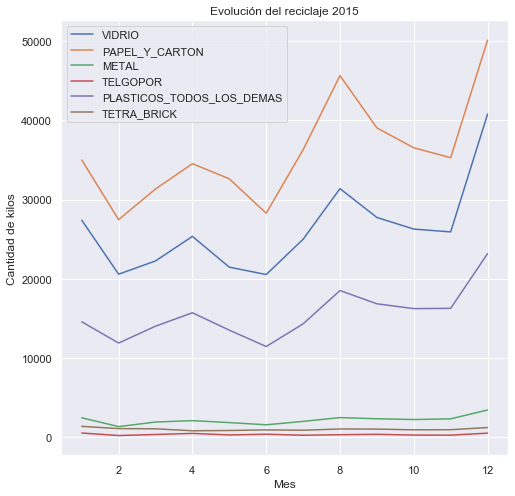

In [42]:
## Vemos la estacionalidad en el año 2015

plt.figure(figsize=(8,8))
plt.plot(anio2015['MES'], anio2015['VIDRIO'], label='VIDRIO');
plt.plot(anio2015['MES'], anio2015['PAPEL_Y_CARTON'], label='PAPEL_Y_CARTON');
plt.plot(anio2015['MES'], anio2015['METAL'], label='METAL');
plt.plot(anio2015['MES'], anio2015['TELGOPOR'], label='TELGOPOR');
plt.plot(anio2015['MES'], anio2015['PLASTICOS_TODOS_LOS_DEMAS'], label='PLASTICOS_TODOS_LOS_DEMAS');
plt.plot(anio2015['MES'], anio2015['TETRA_BRICK'], label='TETRA_BRICK');
plt.legend(loc='upper left')
plt.title('Evolución del reciclaje 2015')
plt.ylabel('Cantidad de kilos')
plt.xlabel('Mes')
plt.show()

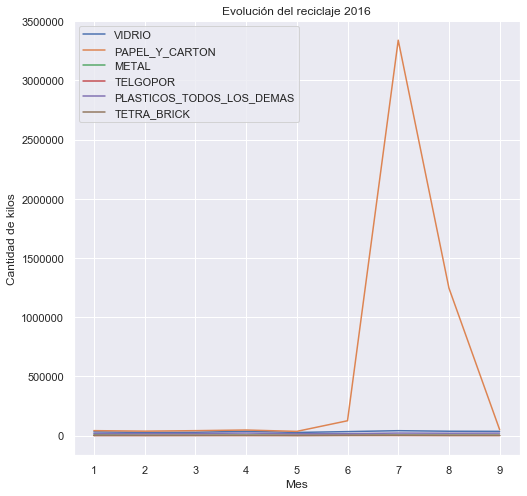

In [43]:
## Vemos la estacionalidad en el año 2016

plt.figure(figsize=(8,8))
plt.plot(anio2016['MES'], anio2016['VIDRIO'], label='VIDRIO');
plt.plot(anio2016['MES'], anio2016['PAPEL_Y_CARTON'], label='PAPEL_Y_CARTON');
plt.plot(anio2016['MES'], anio2016['METAL'], label='METAL');
plt.plot(anio2016['MES'], anio2016['TELGOPOR'], label='TELGOPOR');
plt.plot(anio2016['MES'], anio2016['PLASTICOS_TODOS_LOS_DEMAS'], label='PLASTICOS_TODOS_LOS_DEMAS');
plt.plot(anio2016['MES'], anio2016['TETRA_BRICK'], label='TETRA_BRICK');
plt.legend(loc='upper left')
plt.title('Evolución del reciclaje 2016')
plt.ylabel('Cantidad de kilos')
plt.xlabel('Mes')
plt.show()


### Finalmente en la estacionalidad de los pesajes podemos observar que los meses de mayor reciclado son Abril y Julio en ambos años y se obvserva otro pico en Diciembre de 2015, que decrece lentamente en enero de 2016. Por otro lado vemos que el meses de menor reciclado son Mayo y Febrero